# HDD Predictive Maintenance - Felix - SQL Getting the Data

In this notebook we treat the prediction of HDD breakdown as a classification problem. We think about what data to use and how to preprocess it. Afterwards we have a first look on the features and perform a first EDA.

The notebook is structured as follows:
1. 

## Setup workspace and load data

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from sklearn.feature_selection import mutual_info_classif

RSEED = 42

In [2]:
df = pd.read_csv("../../data/raw/ST4000DM000_history_total.csv", parse_dates=["date"])

## Structure

We backup the dataframe

In [3]:
df_backup = df.copy()

In [4]:
df.shape

(463089, 179)

In [5]:
pd.value_counts(df.dtypes)

float64           174
object              2
int64               2
datetime64[ns]      1
dtype: int64

### Non-numerical features

In [6]:
df.select_dtypes(exclude="number").head()

,date,serial_number,model
0,2020-09-18,Z304JG86,ST4000DM000
1,2020-09-18,S301GMGZ,ST4000DM000
2,2020-09-18,S300YQTN,ST4000DM000
3,2020-09-18,Z302T8AB,ST4000DM000
4,2020-09-18,Z302SXFH,ST4000DM000


In [7]:
df.describe(exclude='number', datetime_is_numeric=True)

,date,serial_number,model
count,463089,463089,463089
unique,NaN,608,1
top,NaN,Z304GSQ0,ST4000DM000
freq,NaN,1096,463089
mean,2020-02-16 07:05:18.923576320,NaN,NaN
min,2019-01-01 00:00:00,NaN,NaN
25%,2019-07-10 00:00:00,NaN,NaN
50%,2020-01-18 00:00:00,NaN,NaN
75%,2020-08-29 00:00:00,NaN,NaN
max,2021-12-31 00:00:00,NaN,NaN


### Numerical features

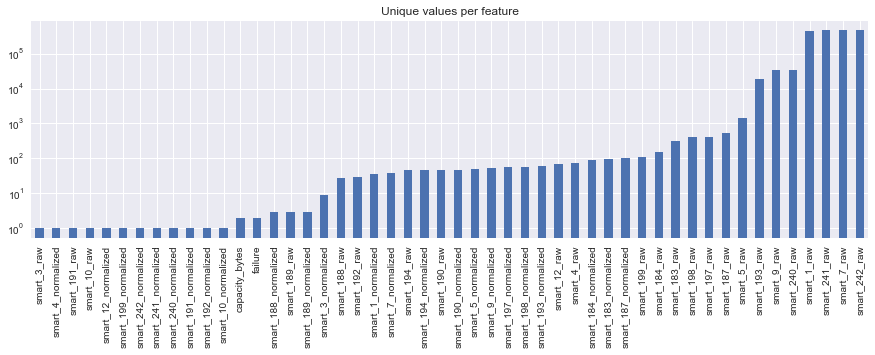

In [8]:
# For each numerical feature compute number of unique entries
unique_values = df.select_dtypes(include="number").nunique().sort_values()
# Only show numerical features with reported values
unique_values = unique_values[unique_values > 0]
# Plot information with y-axis in log-scale
unique_values.plot.bar(logy=True, figsize=(15, 4), title="Unique values per feature");

## Data quality

### Duplicates

In [9]:
# Check number of duplicates while ignoring the index feature
n_duplicates = df.duplicated().sum()
print(f"You seem to have {n_duplicates} duplicates in your database.")

You seem to have 167 duplicates in your database.


In [10]:
shape_old = df.shape
df = df.drop_duplicates()
print(f"Dropped {shape_old[0] - df.shape[0]} rows.")

Dropped 167 rows.


### Missing values

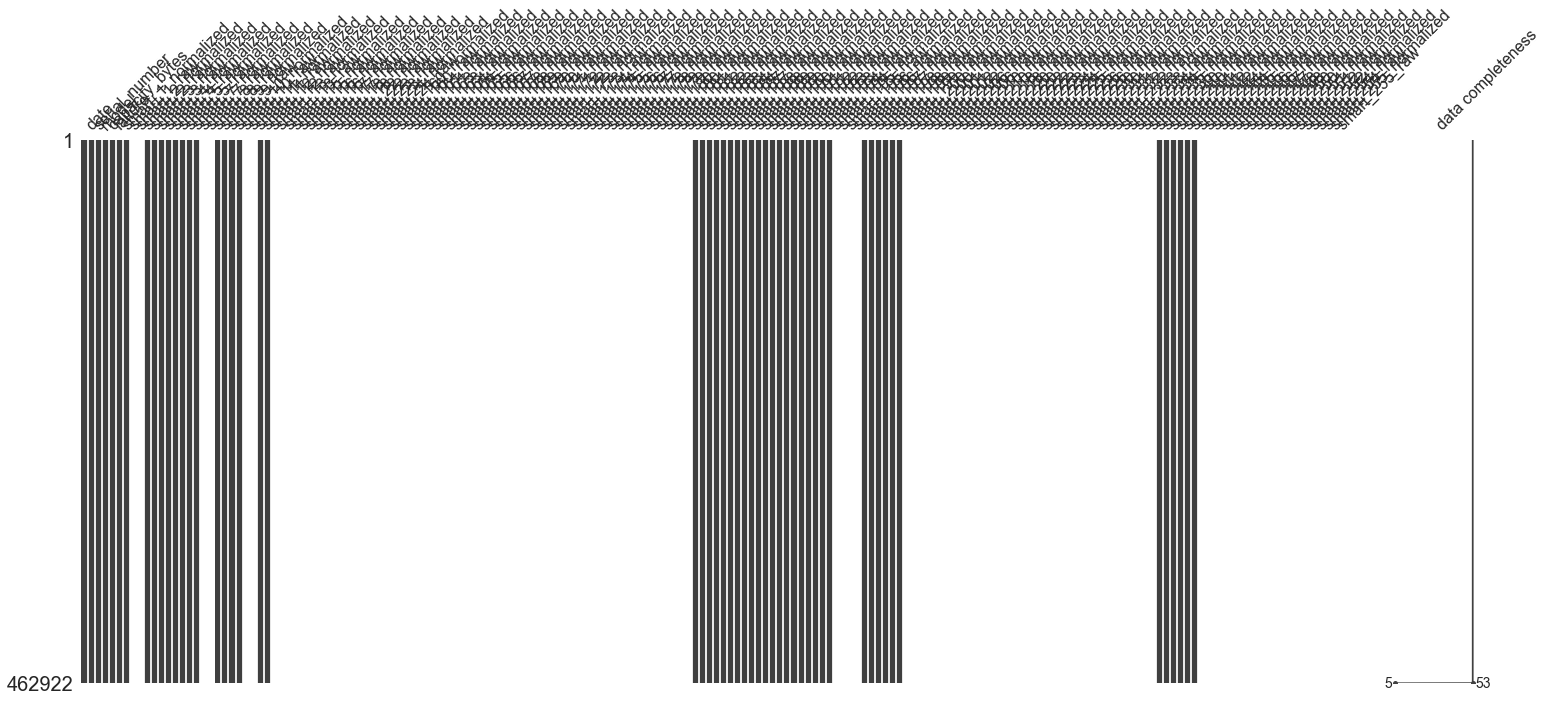

In [12]:
import missingno as msno

msno.matrix(df, labels=True, sort="descending");

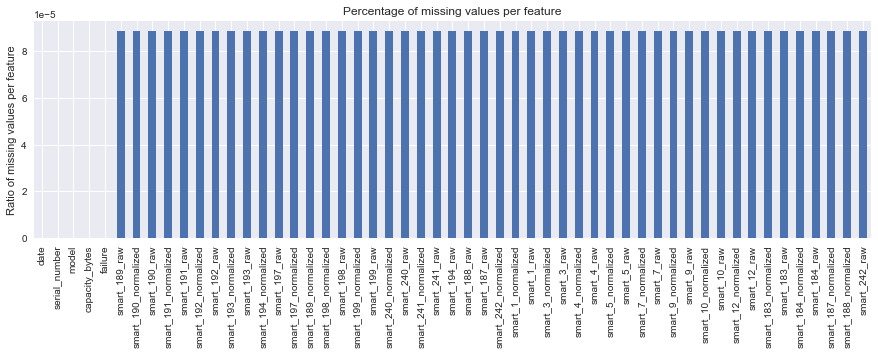

In [19]:
df.isna().mean().sort_values().plot(
    kind="bar", figsize=(15, 4),
    title="Percentage of missing values per feature",
    ylabel="Ratio of missing values per feature");

In [16]:
df = df.dropna(thresh=df.shape[0] * 0.85, axis=1)
df.shape

(462922, 53)

Can also drop samples with many missings

In [20]:
df = df.dropna(thresh=df.shape[1] * 0.80, axis=0).reset_index(drop=True)
df.shape

(462881, 53)

### Recording errors

### Numerical Features

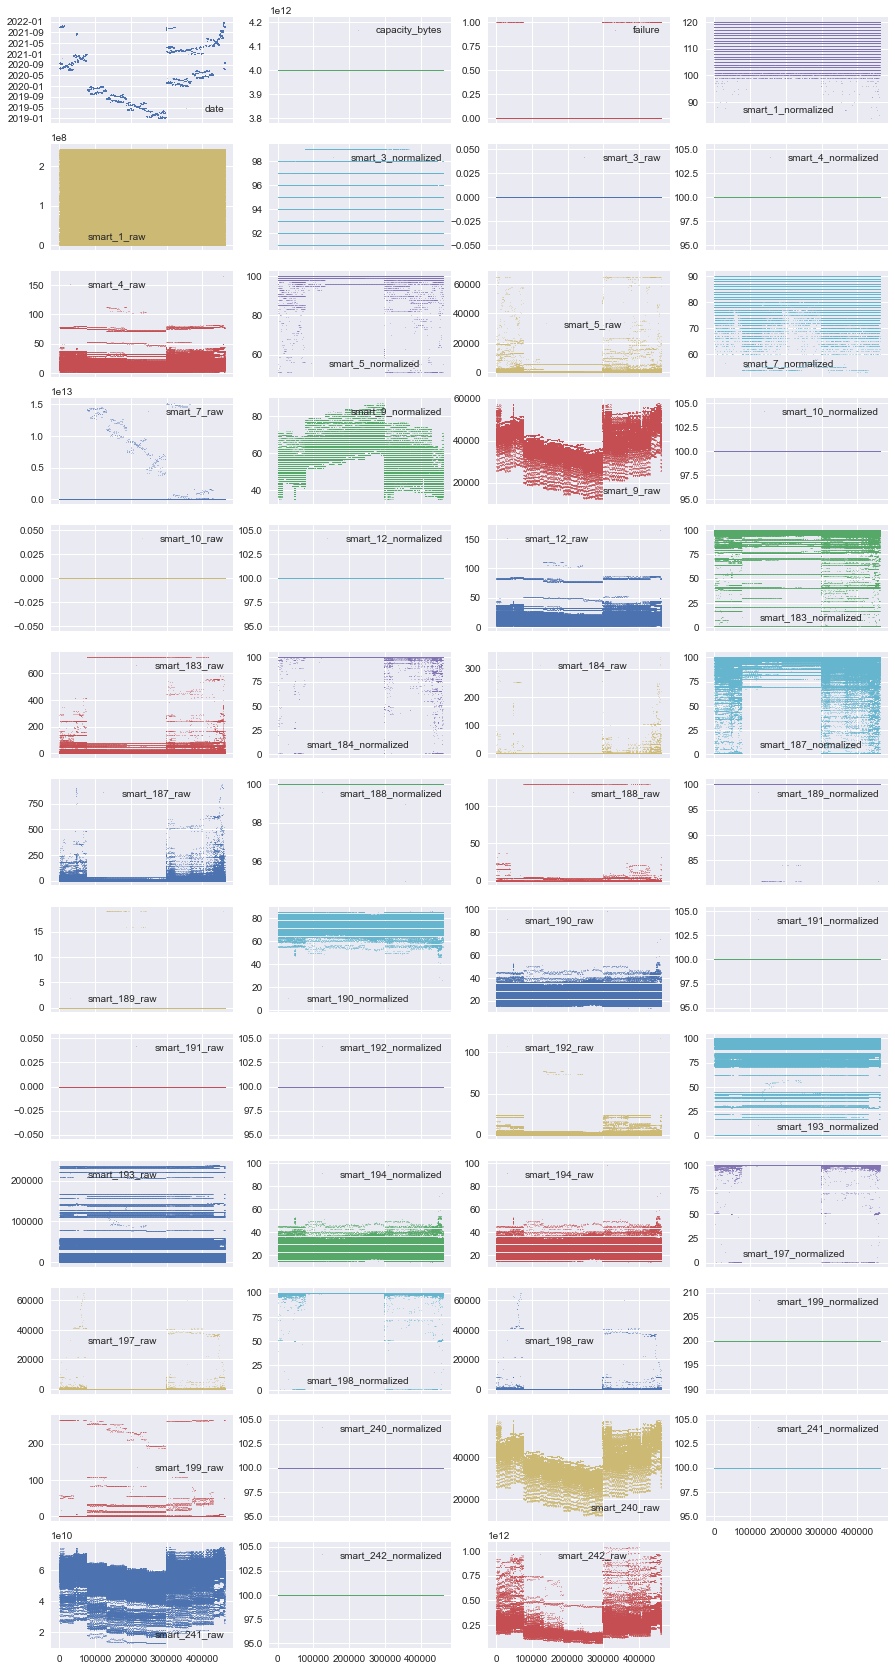

In [22]:
df.plot(lw=0, marker=".", subplots=True, layout=(-1, 4),
          figsize=(15, 30), markersize=1);

### Non-numerical features

In [24]:
# Extract descriptive properties of non-numerical features
df.describe(exclude=["number", "datetime"])

,serial_number,model
count,462881,462881
unique,608,1
top,Z304GSQ0,ST4000DM000
freq,1094,462881


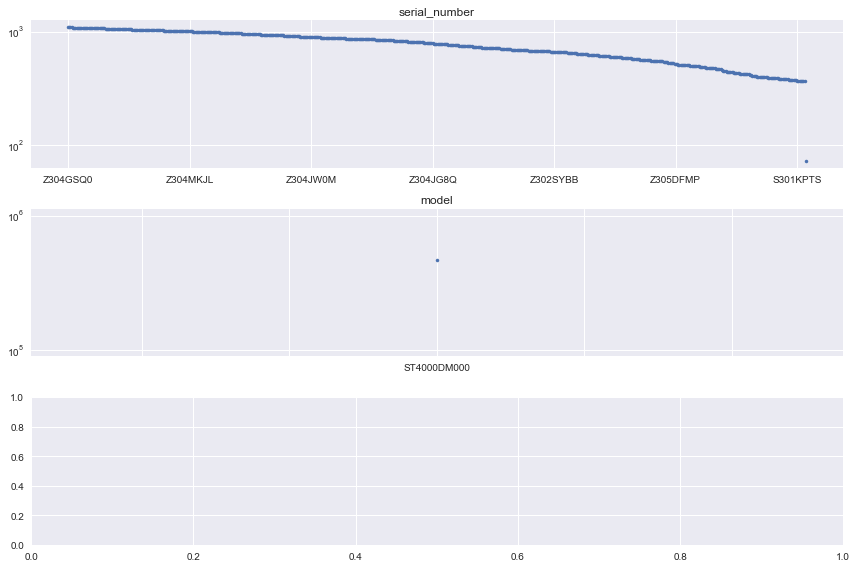

In [26]:
# Create figure object with 3 subplots
fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(12, 8))

# Identify non-numerical features
df_non_numerical = df.select_dtypes(exclude=["number", "datetime"])

# Loop through features and put each subplot on a matplotlib axis object
for col, ax in zip(df_non_numerical.columns, axes.ravel()):

    # Selects one single feature and counts number of occurrences per unique value
    df_non_numerical[col].value_counts().plot(

        # Plots this information in a figure with log-scaled y-axis
        logy=True, title=col, lw=0, marker=".", ax=ax)
    
plt.tight_layout();

## Content

### Feature distribution

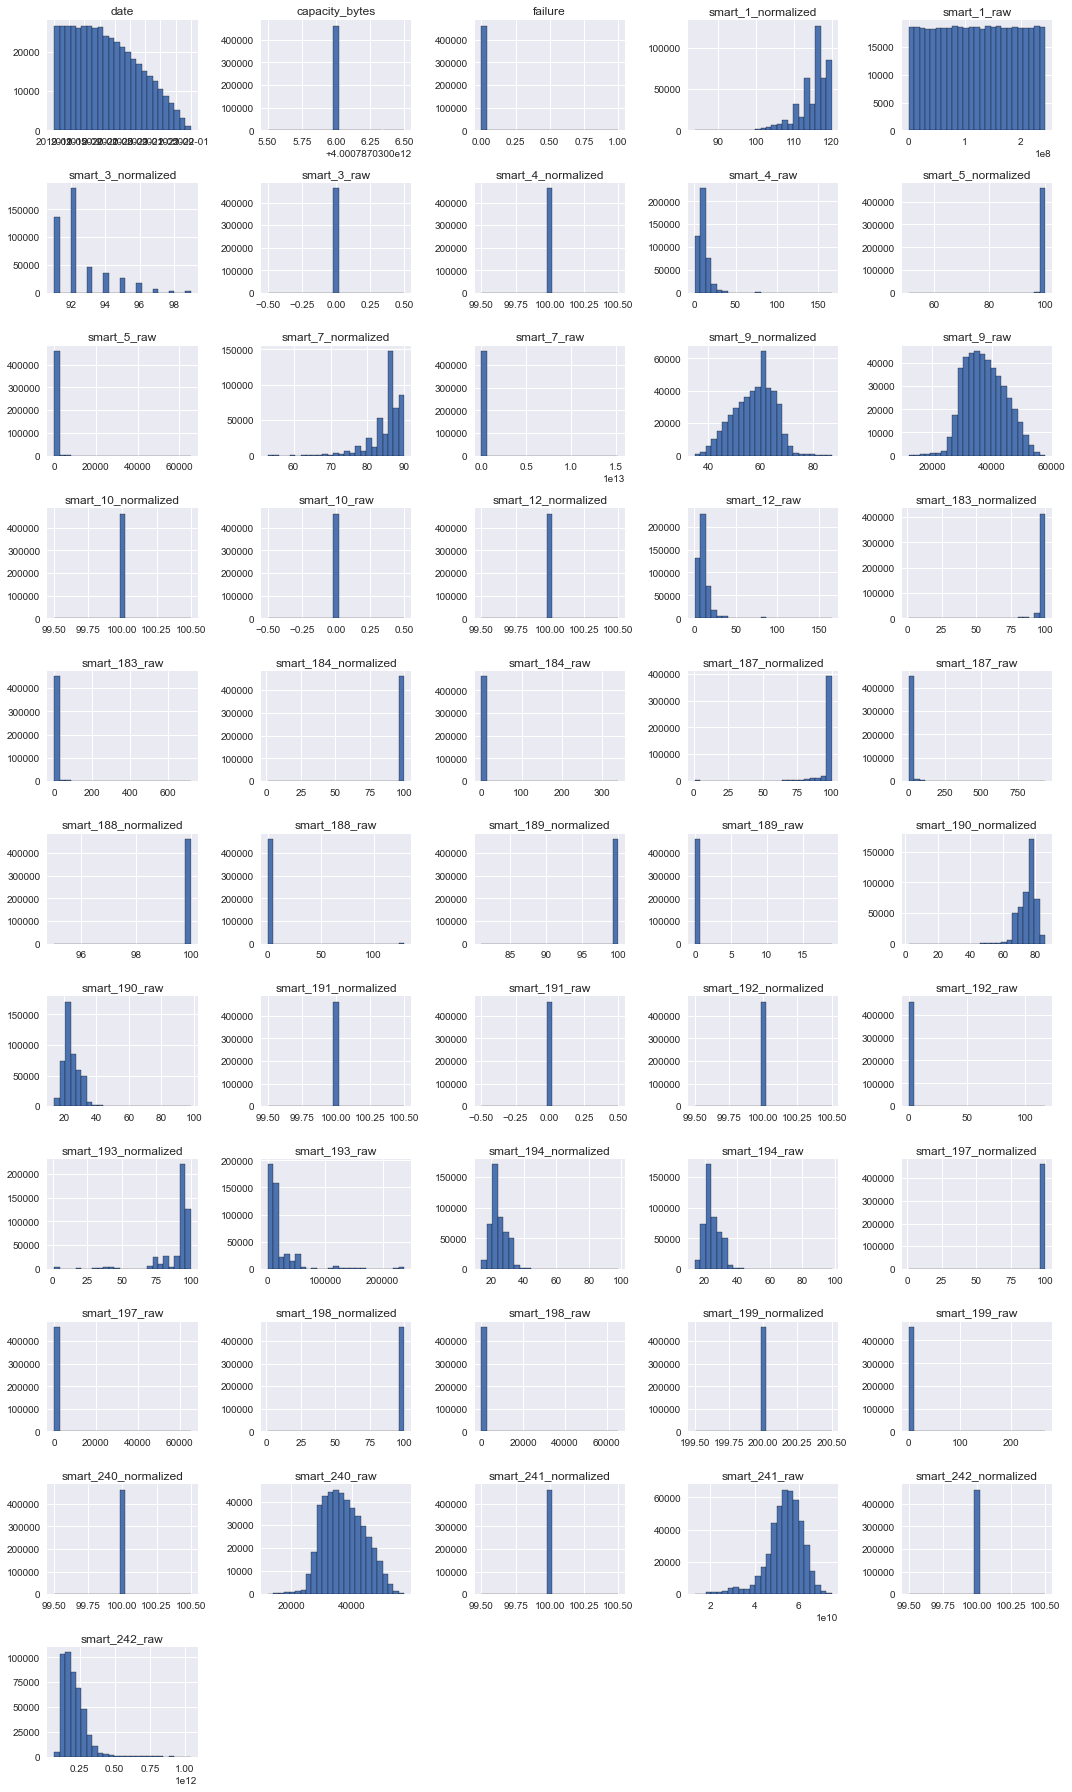

In [27]:
# Plots the histogram for each numerical feature in a separate subplot
df.hist(bins=25, figsize=(15, 25), layout=(-1, 5), edgecolor="black")
plt.tight_layout();

smart_199_normalized    1.0
smart_3_raw             1.0
smart_10_normalized     1.0
smart_240_normalized    1.0
smart_241_normalized    1.0
dtype: float64


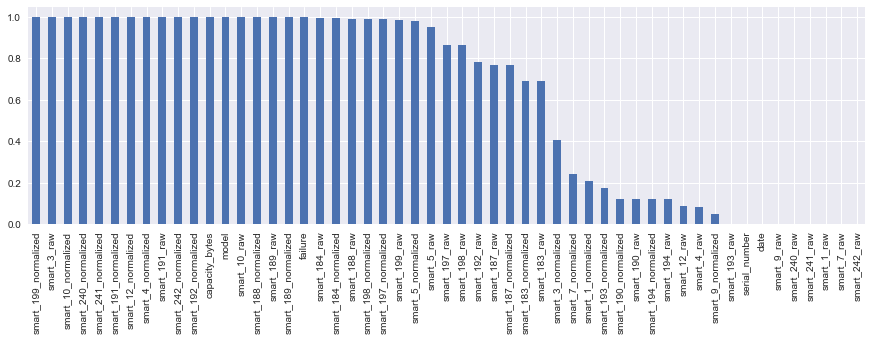

In [34]:
# Collects for each feature the most frequent entry
most_frequent_entry = df.mode()

# Checks for each entry if it contains the most frequent entry
df_freq = df.eq(most_frequent_entry.values[0,:], axis=1)

# Computes the mean of the 'is_most_frequent' occurrence
df_freq = df_freq.mean().sort_values(ascending=False)

# Show the 5 top features with the highest ratio of singular value content
print(df_freq.head())

# Visualize the 'df_freq' table
df_freq.plot.bar(figsize=(15, 4));

### Feature patterns

In [36]:
# Creates mask to identify numerical features with more or less than 25 unique features
cols_continuous = df.select_dtypes(include="number").nunique() >= 25

### Continuous features

In [37]:
# Create a new dataframe which only contains the continuous features
df_continuous = df[cols_continuous[cols_continuous].index]
df_continuous.shape

(462881, 32)

Use pairplot with up to around 10 features

In [ ]:
# sns.pairplot(df_continuous, height=1.5, plot_kws={"s": 2, "alpha": 0.2});

### Discrete features

In [38]:
# Create a new dataframe which doesn't contain the numerical continuous features
df_discrete = df[cols_continuous[~cols_continuous].index]
df_discrete.shape

(462881, 18)

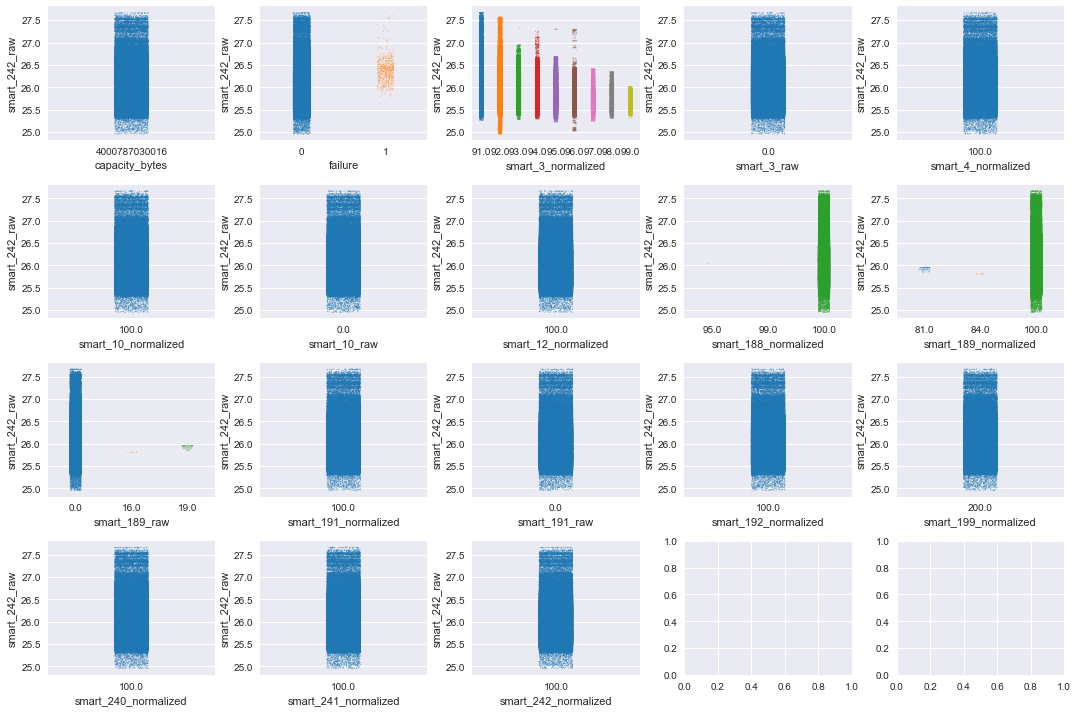

In [42]:
import numpy as np

# Establish number of columns and rows needed to plot all features
n_cols = 5
n_elements = len(df_discrete.columns)
n_rows = np.ceil(n_elements / n_cols).astype("int")

# Specify y_value to spread data (ideally a continuous feature)
y_value = np.log(df["smart_242_raw"]+1)

# Create figure object with as many rows and columns as needed
fig, axes = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(15, n_rows * 2.5))

# Loop through features and put each subplot on a matplotlib axis object
for col, ax in zip(df_discrete.columns, axes.ravel()):
    sns.stripplot(data=df, x=col, y=y_value, ax=ax, palette="tab10", size=1, alpha=0.5)
plt.tight_layout();

### Feature correlation

In [43]:
df_corr = df.corr(method="pearson")

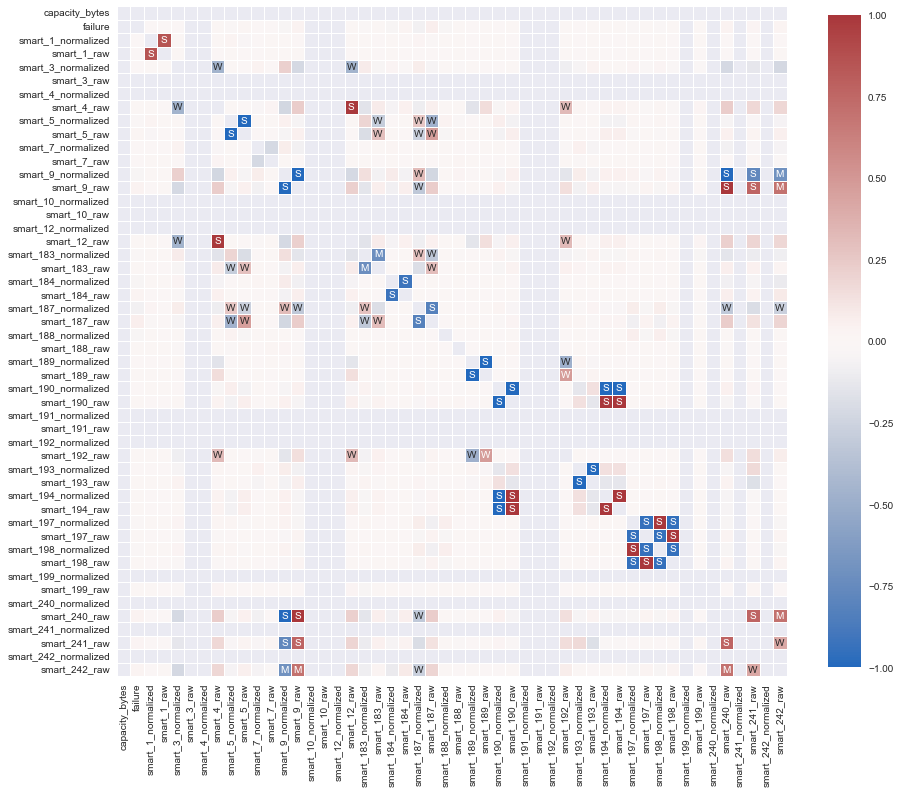

In [44]:
# Create labels for the correlation matrix
labels = np.where(np.abs(df_corr)>0.75, "S",
                  np.where(np.abs(df_corr)>0.5, "M",
                           np.where(np.abs(df_corr)>0.25, "W", "")))

# Plot correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(df_corr, mask=np.eye(len(df_corr)), square=True,
            center=0, annot=labels, fmt='', linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.8});

In [45]:
#  Creates a mask to remove the diagonal and the upper triangle.
lower_triangle_mask = np.tril(np.ones(df_corr.shape), k=-1).astype("bool")

#  Stack all correlations, after applying the mask
df_corr_stacked = df_corr.where(lower_triangle_mask).stack().sort_values()

#  Showing the lowest and highest correlations in the correlation matrix
display(df_corr_stacked)

smart_190_raw         smart_190_normalized   -1.000000
smart_194_normalized  smart_190_normalized   -1.000000
smart_194_raw         smart_190_normalized   -1.000000
smart_189_raw         smart_189_normalized   -1.000000
smart_9_raw           smart_9_normalized     -0.999314
                                                ...   
smart_194_raw         smart_190_raw           1.000000
smart_198_normalized  smart_197_normalized    1.000000
smart_194_normalized  smart_190_raw           1.000000
smart_194_raw         smart_194_normalized    1.000000
smart_198_raw         smart_197_raw           1.000000
Length: 666, dtype: float64

# TODO: Scaling

# TODO: Hypothesis

We calculate the capacity (TB) of the HDDs

In [82]:
df["capacity"] = round(df.capacity_bytes / 1.0e12, 2) # Capacity in Terabyte
df.drop("capacity_bytes", axis=1, inplace=True)
df.capacity.unique()

array([4.00078703])

Next we drop the `normalized` S.M.A.R.T. features

In [83]:
cols_to_drop = df.columns[df.columns.str.contains("normalized")] # Column names that contain normalized
print("Number of columns to drop:", len(cols_to_drop))
df.drop(cols_to_drop, axis=1, inplace=True) # Drop the cols
print("Shape of the dataframe", df.shape)

Number of columns to drop: 87
Shape of the dataframe (1254, 92)


Drop columns with more than 20% NaNs

In [84]:
cols_to_drop = df.columns[df.notna().sum() < (0.8 * len(df))] # Columns that contain lot of NaNs
print("Number of columns to drop:", len(cols_to_drop))
df.drop(cols_to_drop, axis=1, inplace=True) # Drop the cols
print("Shape of the dataframe", df.shape)

Number of columns to drop: 63
Shape of the dataframe (1254, 29)


In [85]:
df.columns

Index(['date', 'serial_number', 'model', 'smart_1_raw', 'smart_3_raw',
       'smart_4_raw', 'smart_5_raw', 'smart_7_raw', 'smart_9_raw',
       'smart_10_raw', 'smart_12_raw', 'smart_183_raw', 'smart_184_raw',
       'smart_187_raw', 'smart_188_raw', 'smart_189_raw', 'smart_190_raw',
       'smart_191_raw', 'smart_192_raw', 'smart_193_raw', 'smart_194_raw',
       'smart_197_raw', 'smart_198_raw', 'smart_199_raw', 'smart_240_raw',
       'smart_241_raw', 'smart_242_raw', 'fail_30_days', 'capacity'],
      dtype='object')

**Description of the features**
- **`date`**: datetime
- **`serial_number`**: unique identifier
- **`model`**: model number
- **`failure`**: target
- **`capacity`**: HDD capacity in TB
- `smart1`: read error rate
- `smart3`: spin-up time
- `smart4`: start-stop count
- `smart5`: reallocated sectors count, **CRITICAL**
- `smart7`: seek error rate
- `smart9`: power on hours (expected: 5 years corresponds to 43 800 hours)
- `smart10`: spin retry count, **CRITICAL**
- `smart12`: power cycle count
- `smart183`: Seagate: downshift error count (sign of aging but no direct indicator)
- `smart184`: end-to-end-error, **CRITICAL**
- `smart187`: uncorrectable errors, **CRITICAL**
- `smart188`: command timeout, should be zero, **CRITICAL**
- `smart189`: high fly writes
- `smart190`: temperature difference, 100°C - temp, here: same values as `smart194`
- `smart191`: g-sense error rate (externally induced shock, vibration)
- `smart192`: unsafe shutdown count
- `smart193`: load cycle count (power saving, rated for 300 000 to 600 000)
- `smart194`: temperature
- `smart197`: count of unstable sectors, **CRITICAL**
- `smart198`: count of uncorrectable sectors, **CRITICAL**
- `smart199`: error count for transfer with interface cable, here always 0!
- `smart240`: head flying hours
- `smart241`: total LBA written
- `smart242`: total LBA read

We obtain no information from `smart190` and `smart199`, so we drop them in the following.

In [86]:
df.drop(["smart_190_raw", "smart_199_raw"], axis=1, inplace=True)
print("Shape of the dataframe", df.shape)

Shape of the dataframe (1254, 27)


In [87]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
smart_1_raw,1254.0,1.240863e+08,7.122809e+07,3.758880e+05,6.429975e+07,1.258232e+08,1.869394e+08,2.440375e+08
smart_3_raw,1254.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
smart_4_raw,1254.0,1.361085e+01,8.835650e+00,1.000000e+00,9.000000e+00,1.200000e+01,1.500000e+01,8.200000e+01
smart_5_raw,1254.0,2.744689e+02,3.291029e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.469600e+04
smart_7_raw,1254.0,6.436167e+08,1.757250e+09,5.686000e+03,2.204148e+08,4.714212e+08,7.735713e+08,3.925885e+10
smart_9_raw,1254.0,4.484620e+04,5.471557e+03,2.401200e+04,4.065675e+04,4.556900e+04,4.912200e+04,5.769200e+04
smart_10_raw,1254.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
smart_12_raw,1254.0,1.340670e+01,9.174750e+00,1.000000e+00,9.000000e+00,1.200000e+01,1.500000e+01,8.700000e+01
smart_183_raw,1254.0,6.332536e+00,3.006352e+01,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,5.590000e+02
smart_184_raw,1254.0,1.175439e+00,1.352434e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.330000e+02


A few findings:
- `smart3` spin-up time reported is 0 for all HDDs -> drop it
- `smart10` critical critereon all 0, don't use for now, might be interesting to find HDDs with non 0
- `smart 191` all 0 (no externally induced shocks)
- `capacity` always the same for the same model, makes sense

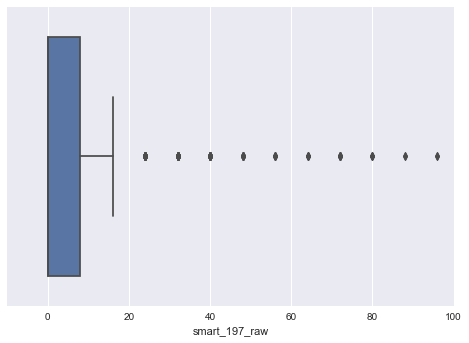

In [90]:
sns.boxplot(df.smart_197_raw)
plt.xlim(-10, 100);

Calculate correlations and mutual information score

In [107]:
df.fail_30_days.fillna(0, inplace=True) # Fill missing target --> check indexing above!!!

In [205]:
scores = mutual_info_classif(df.drop(["fail_30_days", "date", "model", "capacity", "serial_number"], axis=1), df.fail_30_days)
col_names = df.drop(["fail_30_days", "date", "model", "capacity", "serial_number"], axis=1).columns
scores = pd.DataFrame(scores, index=col_names, columns=["MI Score"])
scores["Correlation"] = df.corr().fail_30_days
scores = scores.sort_values("MI Score", ascending=False)
scores.head(10)

,MI Score,Correlation
smart_9_raw,0.167323,0.489537
smart_240_raw,0.154079,0.487189
smart_242_raw,0.118578,0.322942
smart_241_raw,0.062460,0.210865
smart_187_raw,0.049167,0.298454
smart_198_raw,0.036523,0.029188
smart_192_raw,0.035757,0.169440
smart_184_raw,0.034552,0.106533
smart_5_raw,0.028123,0.093682
smart_197_raw,0.024795,0.029188


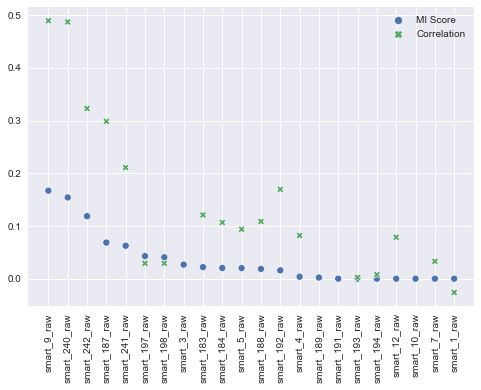

In [110]:
sns.scatterplot(data=scores.sort_values("MI Score", ascending=False))
plt.xticks(rotation=90);

## Details of the most important features

In [206]:
feats = scores.head(5).index
feats

Index(['smart_9_raw', 'smart_240_raw', 'smart_242_raw', 'smart_241_raw',
       'smart_187_raw'],
      dtype='object')

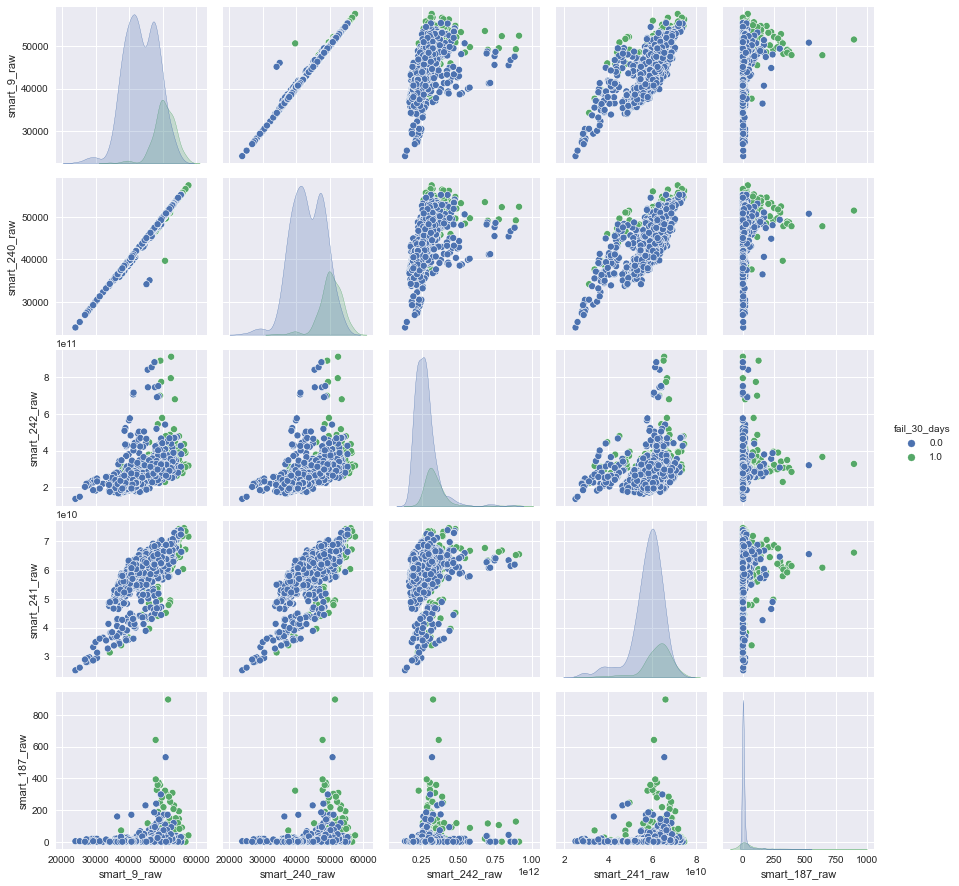

In [207]:
feats = ['smart_9_raw', 'smart_240_raw', 'smart_242_raw', 'smart_241_raw', 'smart_187_raw', 'fail_30_days']
sns.pairplot(data=df[feats], hue="fail_30_days");

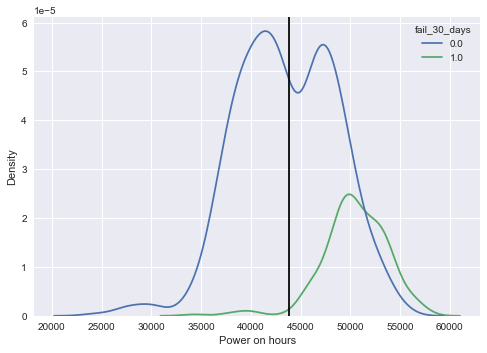

In [251]:
sns.kdeplot(data=df, x="smart_9_raw", hue="fail_30_days", common_norm=True)
plt.axvline(x=43800, color='k')
plt.xlabel("Power on hours");

(0.0, 100.0)

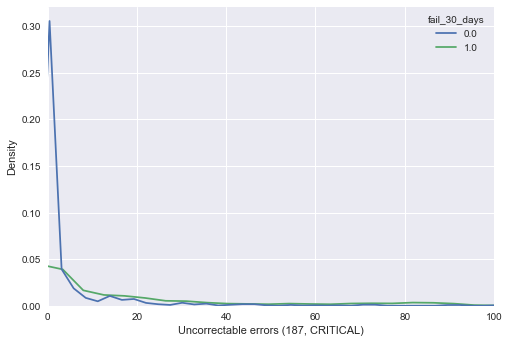

In [225]:
sns.kdeplot(data=df, x="smart_187_raw", hue="fail_30_days", common_norm=False, bw_adjust=0.1)
plt.xlabel("Uncorrectable errors (187, CRITICAL)")
plt.xlim(0,100)
#plt.ylim(0, 100);

Text(0.5, 0, 'Temperature °C')

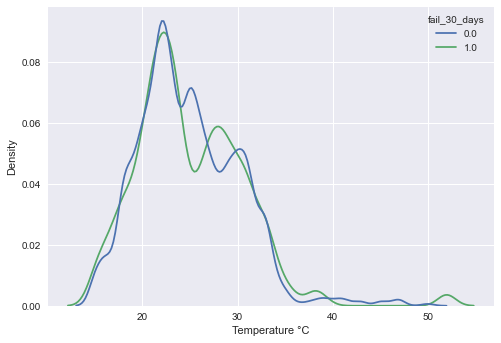

In [242]:
sns.kdeplot(data=df, x="smart_194_raw", hue="fail_30_days", common_norm=False, bw_adjust=0.5)
plt.xlabel('Temperature °C')


Dimensionality Reduction

In [322]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

scaler = StandardScaler()
pca = PCA()
tsne = TSNE(n_components=2, init='random', random_state=RSEED)

(1254, 10)


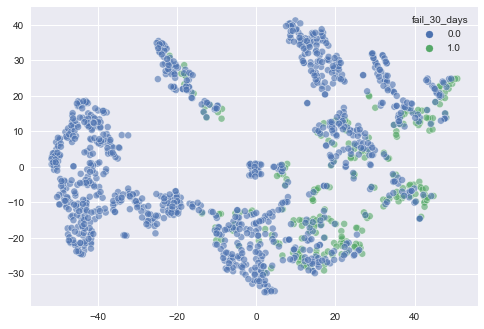

In [323]:
feats = scores.head(10).index
X = df[feats]
y = df.fail_30_days

X = scaler.fit_transform(X)
X_tsne = tsne.fit_transform(X)
X_pca = pca.fit_transform(X)
print(X_pca.shape)

sns.scatterplot(X_tsne[:, 0], X_tsne[:, 1], hue=y, alpha=0.6);